<a href="https://colab.research.google.com/github/pchatfield/coin-analyzer/blob/main/country_coin_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Coin Classifier

- This notebook uses Deep Learning methods to classify the country a coin was minted in using a dataset of images of coins from 32 different countries.

In [1]:
# imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator, img_to_array, image
from keras.utils import np_utils
import json
from PIL import Image
import numpy as np

In [2]:
# import data from drive

from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/My Drive/Data Science Projects/Country_coins"

Mounted at /content/drive


In [3]:
# split data into training and validation sets

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size)

Found 8110 files belonging to 32 classes.
Using 6488 files for training.
Found 8110 files belonging to 32 classes.
Using 1622 files for validation.


In [4]:
# data augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.4),
    ]
)

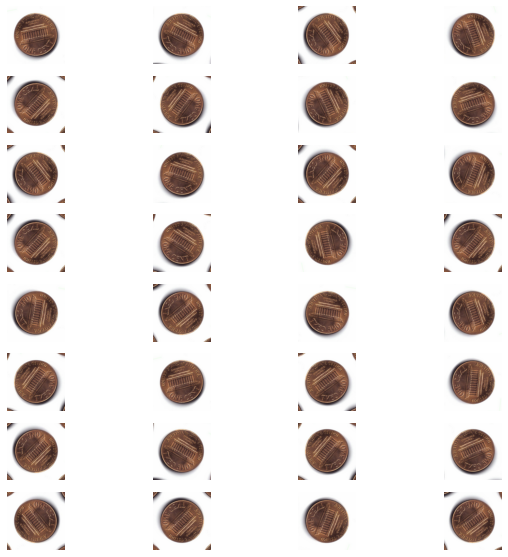

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(32):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
# buffered prefetching

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

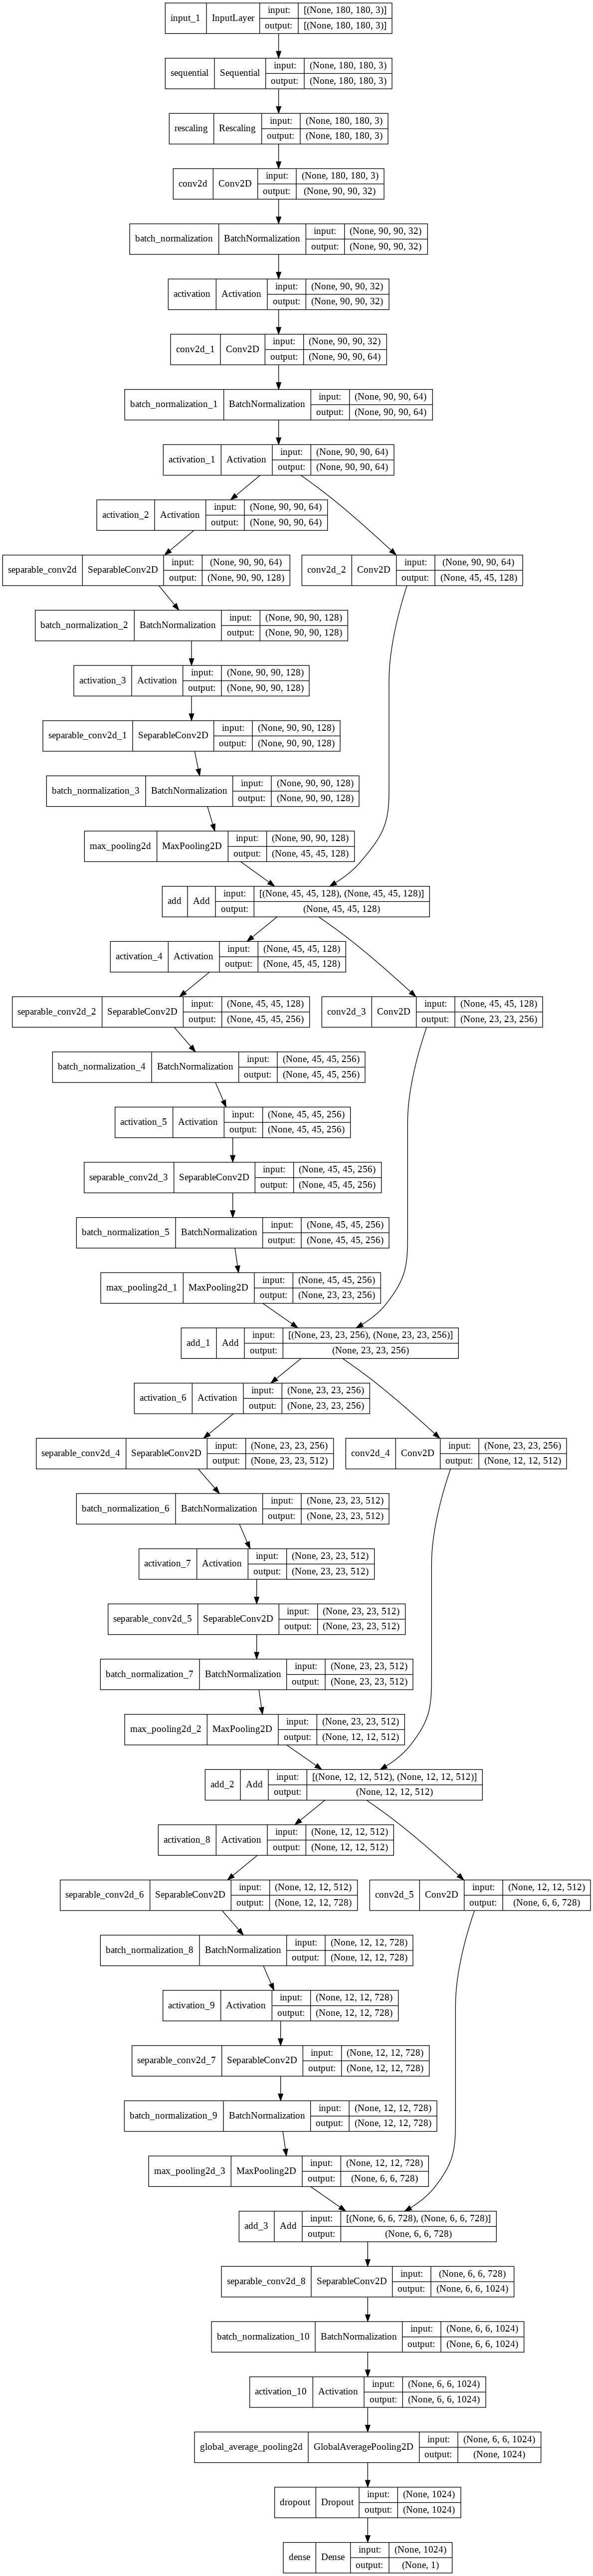

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [10]:
epochs = 5

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
model.compile(
    optimizer=keras.optimizers.Adam(1e-1),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
# model.fit(
#     train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
# )

model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/5
203/203 [==============================] - 107s 512ms/step - loss: -4776254.0000 - accuracy: 0.0240 - val_loss: -39565804.0000 - val_accuracy: 0.0148
Epoch 2/5
203/203 [==============================] - 103s 501ms/step - loss: -38263156.0000 - accuracy: 0.0240 - val_loss: -106181000.0000 - val_accuracy: 0.0148
Epoch 3/5
203/203 [==============================] - 103s 504ms/step - loss: -107567392.0000 - accuracy: 0.0240 - val_loss: -235237328.0000 - val_accuracy: 0.0148
Epoch 4/5
203/203 [==============================] - 102s 498ms/step - loss: -209864096.0000 - accuracy: 0.0240 - val_loss: -289516832.0000 - val_accuracy: 0.0148
Epoch 5/5
203/203 [==============================] - 101s 495ms/step - loss: -342382496.0000 - accuracy: 0.0240 - val_loss: -440226720.0000 - val_accuracy: 0.0148
